### Clustering

In [1]:
import re
import random
import spacy
import numpy as np
import itertools
import collections
import functools
import operator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.metrics.pairwise import euclidean_distances

Load data

In [2]:
def load_data(path):
    func_names = []
    func_types = []
    with open(path, "r") as file:
        for name, *types in map(lambda x: x.strip().split(","), file.readlines()):
            func_types.append(types)
            func_names.append(name)
    return func_names, func_types

def printk(funcs, k=10, show_sort=True, nmap=None, rand=False):
    print(f"#funcs={len(funcs)}\nfuncs:")
    indices = random.choices(range(len(funcs)), k=k) if rand else range(k)
    print(*((funcs[i], nmap[funcs[i]]) if nmap else funcs[i] for i in indices), sep='\n')
    if show_sort:
        print("\nsorted:", *((f, nmap[f]) if nmap else f for f, _ in zip(sorted(funcs), range(k))), sep='\n')

func_names, func_types = load_data("functions.txt")
printk(func_names)

#funcs=2866671
funcs:
findReferencedDecl
INSTANTIATE_TEST_CASE_P
butterfly_mk_initpgm
vega20_od8_get_gfx_clock_base_voltage
CL_AddRef
_wrap_new_Yield__SWIG_0
bdblib_create_dbenv
fetch_and_nand_1
sms_ir_event
put_qcd

sorted:
$$$$$$_PauseResumeOverheadOnce
$$$$$$_PauseResumeOverheadThrice
$$$$$$_PauseResumeOverheadTwice
$$RTX$$version
$$USBD$$version
$$divI
$$divI_10
$$divI_12
$$divI_14
$$divI_15


Drop wrong names

In [3]:
def drop_wrong_names(func_names, func_types):
    re_ident = re.compile(rf"^[a-zA-Z_][a-zA-Z_0-9]*$", re.UNICODE)
    func_names, func_types = map(list, zip(*(itertools.filterfalse(lambda x: not re_ident.fullmatch(x[0]),
                                                                 zip(func_names, func_types)))))
    return func_names, func_types

func_names, func_types = drop_wrong_names(func_names, func_types)
printk(func_names)

#funcs=2864432
funcs:
findReferencedDecl
INSTANTIATE_TEST_CASE_P
butterfly_mk_initpgm
vega20_od8_get_gfx_clock_base_voltage
CL_AddRef
_wrap_new_Yield__SWIG_0
bdblib_create_dbenv
fetch_and_nand_1
sms_ir_event
put_qcd

sorted:
A
A
A
A
A
A
A
A
A
A


Split names to tokens

In [4]:
def tokenize_funcs(funcs):
    oneword = re.compile(r"^[a-z][a-z0-9]+|[A-Z][A-Z0-9]$")
    difCase = re.compile(r".+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)")
    under_scores_split = re.compile(r"_")

    tokenized_funcs = []
    for f in funcs:
        if oneword.fullmatch(f):
            tokenized_funcs.append([f])
        elif "_" in f:
            tokenized_funcs.append([w for w in under_scores_split.split(f) if w])
        else:
            tokenized_funcs.append([w.group(0) for w in difCase.finditer(f) if w.group(0)])
    return tokenized_funcs

tokenized_func_names = tokenize_funcs(func_names)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=2864432
funcs:
('loongson_cs5536_isa_fixup', ['loongson', 'cs5536', 'isa', 'fixup'])
('pmic_irq_sync_unlock', ['pmic', 'irq', 'sync', 'unlock'])
('MODULE_SOFTDEP', ['MODULE', 'SOFTDEP'])
('transposeInPlaceCPPTest', ['transpose', 'In', 'Place', 'CPP', 'Test'])
('USBOTGSessionRequest', ['USBOTG', 'Session', 'Request'])
('__quicklistDelNode', ['quicklistDelNode'])
('get_style_prop_attr', ['get', 'style', 'prop', 'attr'])
('_wrap_new_UserRequestType__SWIG_0', ['wrap', 'new', 'UserRequestType', 'SWIG', '0'])
('isif_probe', ['isif', 'probe'])
('readdhstbynamev6', ['readdhstbynamev6'])

sorted:
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])
('A', ['A'])


Drop digits from tokens, convert to low register

In [5]:
def drop_wrong_symbols(func_names, tokenized_func_names, func_types):
    # first approach to drop all digits, second only if > 50%
    wrong_char = re.compile(r"[\d]")
    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [re.sub(wrong_char, "", token).lower()
                            for token in tokenized_name if re.sub(wrong_char, "", token)]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = drop_wrong_symbols(func_names, tokenized_func_names, func_types)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del name2tokens

#funcs=2864422
funcs:
('parseMXML', ['parse', 'mxml'])
('superio_enter', ['superio', 'enter'])
('update_path', ['update', 'path'])
('mergeColumns', ['merge', 'columns'])
('tegra_gpio_set_debounce', ['tegra', 'gpio', 'set', 'debounce'])
('pcap_stats_snit', ['pcap', 'stats', 'snit'])
('EntityCharCorrectDir', ['entity', 'char', 'correct', 'dir'])
('vPortGetIPSR', ['v', 'port', 'get', 'ipsr'])
('uwsgi_lua_websocket_handler_send', ['uwsgi', 'lua', 'websocket', 'handler', 'send'])
('max14577_i2c_probe', ['max', 'ic', 'probe'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])


Split concatenated words to separate tokens

In [6]:
def create_segment_func(tokenized_func_names, c=1, base=1/26, prior=1e-7):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    total_num_words = sum(word2count.values())
    corrected_total_num_words = (len(word2count) + 1) * c + total_num_words
    word2prob1 = {k: v / total_num_words for k, v in word2count.items()}
    word2prob2 = {k: (v + c) / corrected_total_num_words for k, v in word2count.items()}
    unseen_prob = c / corrected_total_num_words
    ones_length2count = collections.Counter(map(len, (word for word, count in word2count.items() if count == 1)))
    ones_longest = max(ones_length2count)
    ones_num_words = sum(ones_length2count.values())

    # naive probability v1
    def prob1(word):
        return word2prob1[word]

    # smoothed probability v1
    def prob2(word):
        return word2prob2[word] if word in word2prob2 else unseen_prob

    # smoothed probability v2
    def prob3(word):
        unseen_estimation = ones_length2count[len(word)] / ones_num_words if len(word) in ones_length2count \
            else ones_length2count[ones_longest] / ones_num_words * base ** (len(word) - ones_longest)
        return word2prob1[word] if word in word2prob1 else prior * unseen_estimation

    def split(word, start=1, end=20):
        return ((word[:i], word[i:]) for i in range(start, min(len(word) + 1, end)))

    @functools.lru_cache(maxsize=10000)
    def segment(word):
        if not word:
            return []
        candidates = ([first] + segment(remaining) for first, remaining in split(word))
        return max(candidates, key=lambda x: functools.reduce(operator.__mul__, map(prob3, x), 1))
    return segment

def segmentize_corpus(tokenized_func_names, segmenter):
    tokenized_func_names = [list(itertools.chain(*(segmenter(token) for token in tokens)))
                            for tokens in tokenized_func_names]
    return tokenized_func_names

segmenter = create_segment_func(tokenized_func_names)
words = ["ccfileutils", "setendframeindex", "inneractionframe", "setsearchresolutionsorder",
         "dynamicmeminit", "wakeupiodisableglobal", "getinit", "getinitz"]
print(*((word, segmenter(word)) for word in words), "", sep='\n')
tokenized_func_names = segmentize_corpus(tokenized_func_names, segmenter)

name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)
del words, name2tokens

('ccfileutils', ['ccfileutils'])
('setendframeindex', ['setendframeindex'])
('inneractionframe', ['inneractionframe'])
('setsearchresolutionsorder', ['set', 'search', 'resolutionsorder'])
('dynamicmeminit', ['dynamicmeminit'])
('wakeupiodisableglobal', ['wakeupiodisable', 'global'])
('getinit', ['get', 'init'])
('getinitz', ['get', 'init', 'z'])

#funcs=2864422
funcs:
('iotx_response_handler', ['iotx', 'response', 'handler'])
('Log', ['log'])
('get_swap_data', ['get', 'swap', 'data'])
('FchInitMidUsbEhci3', ['fch', 'init', 'mid', 'usb', 'ehci'])
('frskyCheckSumFini', ['frsky', 'check', 'sum', 'fini'])
('ParseModuleSection', ['parse', 'module', 'section'])
('cufileInit', ['cufile', 'init'])
('tvbparse_shrink_token_cb', ['tvbparse', 'shrink', 'token', 'cb'])
('samr_dissect_element_ChangePasswordUser3_password3_', ['samr', 'dissect', 'element', 'changepassworduser', 'password'])
('encrypt_buffer', ['encrypt', 'buffer'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['

Lemmatize tokens

In [7]:
print("#uniq tokens before lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")

def lemmatize_corpus(tokenized_func_names):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    lengths = np.cumsum([0] + list(map(len, tokenized_func_names)))
    flat_tokens = list(itertools.chain(*tokenized_func_names))
    doc = spacy.tokens.Doc(nlp.vocab, words=flat_tokens)
    tokenized_func_names = [[token.lemma_ for token in doc[lengths[i - 1]: lengths[i]]]
                            for i in range(1, len(tokenized_func_names) + 1)]
    return tokenized_func_names

tokenized_func_names = lemmatize_corpus(tokenized_func_names)
name2tokens = {f: tokenized_func_names[i] for i, f in enumerate(func_names)}
printk(func_names, nmap=name2tokens, rand=True)

print("\n#uniq tokens after lemmatizing", len(set(itertools.chain(*tokenized_func_names))), "\n")
del name2tokens

#uniq tokens before lemmatizing 235545 

#funcs=2864422
funcs:
('vhost_scsi_stop', ['vhost', 'scsi', 'stop'])
('multi_prog_drop2', ['multi', 'prog', 'drop'])
('m68k_op_move_16_pi_al', ['mk', 'op', 'move', 'pi', 'al'])
('ClearPlrMsg', ['clear', 'plr', 'msg'])
('upb_refcounted_unref2', ['upb', 'refcounted', 'unref'])
('parse_update', ['parse', 'update'])
('LLVMCreateOProfileJITEventListener', ['llvm', 'create', 'o', 'profile', 'jit', 'event', 'listener'])
('setPxVehicleSuspensionDataMSpringStrength', ['set', 'px', 'vehicle', 'suspension', 'datum', 'be', 'spring', 'strength'])
('starttermcap', ['starttermcap'])
('qcom_qmp_phy_exit', ['qcom', 'qmp', 'phy', 'exit'])

sorted:
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])
('A', ['a'])

#uniq tokens after lemmatizing 230299 



Drop rare or uninformative tokens

dict size: 55968

dict:
('get', 210875)
('set', 135377)
('dissect', 134003)
('test', 103847)
('init', 95067)
('read', 59280)
('to', 56446)
('be', 52437)
('write', 49911)
('add', 46887)

reversed dict:
('timo', 5)
('transferreason', 5)
('sfifo', 5)
('slae', 5)
('ugt', 5)
('rcbs', 5)
('isleap', 5)
('registersound', 5)
('cpbstf', 5)
('zptcon', 5)


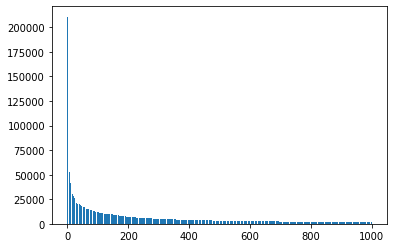

In [8]:
def prune_vocabulary(func_names, tokenized_func_names, func_types, min_ct=5, min_len=2, max_len=20):
    word2count = collections.Counter(itertools.chain(*tokenized_func_names))
    word2count = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=True)
                  if v >= min_ct and min_len <= len(k) <= max_len}
    vocab_low_to_high = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=False)}
    print(f"dict size: {len(word2count)}\n\ndict:")
    print(*((k, v) for _, (k, v) in zip(range(10), word2count.items())), "\nreversed dict:", sep='\n')
    print(*((k, v) for _, (k, v) in zip(range(10), vocab_low_to_high.items())), sep='\n')

    word2ind = {w: i for w, i in zip(word2count.keys(), itertools.count())}
    ind2count = {word2ind[w]: freq for (w, freq), _ in zip(word2count.items(), range(1000))}
    plt.bar(ind2count.keys(), ind2count.values())
    plt.show()

    tokenized_func_names_ = []
    func_types_ = []
    func_names_ = []
    for i, (name, tokenized_name, types) in enumerate(zip(func_names, tokenized_func_names, func_types)):
        processed_tokens = [token for token in tokenized_name if token in word2count]
        if processed_tokens:
            tokenized_func_names_.append(processed_tokens)
            func_types_.append(types)
            func_names_.append(name)

    return func_names_, tokenized_func_names_, func_types_

func_names, tokenized_func_names, func_types = prune_vocabulary(func_names, tokenized_func_names, func_types)

Process types

In [9]:
def tokenize_types(func_types):
    type_set = {
        "int", "unsigned int", "char", "unsigned char", "enum", "struct", "void", "long", "unsigned long",
        "float", "double", "short", "unsigned short", "bool", "union", "long long", "unsigned long long"}
    type_dict = {re.compile(t): t for t in type_set}
    r_drop = re.compile(r"\*|restrict|const")
    struct_type = re.compile("struct")
    tokenized_types = [[0 for _ in range(len(f_types))] for f_types in func_types]
    for i, f_types in enumerate(func_types):
        for j, type in enumerate(f_types):
            cleaned_type = re.sub(r_drop, "", type)
            for re_t, t in type_dict.items():
                if re.search(re_t, cleaned_type):
                    tokenized_types[i][j] = t
                    break
            else:
                tokenized_types[i][j] = type_dict[struct_type]
    return tokenized_types

print(*(func_types[i] for i in range(10)), sep='\n')
tokenized_func_types = tokenize_types(func_types)
print("\n", *(tokenized_func_types[i] for i in range(10)), sep='\n')

['int', 'const int *']
['int', 'tfidf_test', 'tfidf_test', 'int (int &', ' int &', ' int &)', 'int']
['void', 'int *']
['int', 'struct pp_hwmgr *', 'int *', 'int']
['void', 'int *', 'struct CodeEntry *']
['int', 'int', 'int *', 'int']
['int', 'int **', 'char *']
['int', 'volatile int *', 'int']
['void', 'struct smscore_device_t *', 'const char *', 'int']
['int', 'struct (anonymous at repositories/rt-n56u/j2kenc.c:61:9) *', 'int']


['int', 'int']
['int', 'struct', 'struct', 'int', 'int', 'int', 'int']
['void', 'int']
['int', 'struct', 'int', 'int']
['void', 'int', 'struct']
['int', 'int', 'int', 'int']
['int', 'int', 'char']
['int', 'int', 'int']
['void', 'struct', 'char', 'int']
['int', 'struct', 'int']


Construct feature matrix

In [10]:
max_samples = int(1e7)
num_samples = min(max_samples, len(func_names))
func_names, tokenized_func_names, func_types, tokenized_func_types = zip(*(random.sample(
    list(zip(func_names, tokenized_func_names, func_types, tokenized_func_types)), k=num_samples)))
tokenized_features = [tok_name + tok_types for tok_name, tok_types in zip(tokenized_func_names, tokenized_func_types)]
tfidf_matrix = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, sublinear_tf=True)
tfidf_matrix = tfidf_matrix.fit_transform(tokenized_func_names)
print(tfidf_matrix.shape)

(2808542, 55968)


Clustering

In [11]:
n_clusters = 500
n_init = 5
model = KMeans(n_clusters=n_clusters, n_init=n_init)
predictions = model.fit_predict(tfidf_matrix)
# isomap = Isomap(n_components=2)
# transformed = isomap.fit_transform(tfidf_matrix)
# x_axis = transformed[:, 0]
# y_axis = transformed[:, 1]
# plt.scatter(x_axis, y_axis, c=predictions)
# plt.show()
# del transformed, x_axis, y_axis

In [12]:
centers = np.array(model.cluster_centers_)
closest_ct = 10
for i in range(n_clusters):
    center = centers[i].reshape(1, -1)
    cluster_indexes = [j for j, cl in enumerate(predictions) if cl == i]
    cluster_funcs = [func_names[j] for j in cluster_indexes]
    cluster_feats = tfidf_matrix[cluster_indexes, :]
    cluster_dists = euclidean_distances(cluster_feats, center)
    cluster_closest_indexes = np.argpartition(cluster_dists.reshape(-1), closest_ct)
    print(f"cluster{i + 1}")
    for j in range(closest_ct):
        print(cluster_funcs[cluster_closest_indexes[j]])
    print("")

cluster1
disconnect_all
finish_all
DisconnectAll
disconnect_all
disconnect_all
disconnect_all
disconnect_all
disconnect_all
fs_disconnect
fs_cs_disconnected

cluster2
forsythe_inverse
boothroyd_inverse
herndon_inverse
t_inverse
inverse
inverse
milnes_inverse
lotkin_inverse
inverse
a123_inverse

cluster3
IsValid
is_valid
is_valid64
is_valid_dstime
A_is_valid
is_valid
isValid
is_valid
is_valid_persistentkeepalive
is_Valid

cluster4
compareString
stringcompare
stringcompare
string_array_compare
CompareStrings
compare_from_string
StringCompare2
string_compare
StringCompare
compareString

cluster5
width_1
ISO8601IntegerWidth
width
Width
Width
width
ss_width
limage_width
verdana11_width
x_width

cluster6
looping_rc_track_right_bank_to_25_deg_down
looping_rc_track_25_deg_down_to_right_bank
looping_rc_track_right_banked_25_deg_up_to_flat
looping_rc_track_right_banked_25_deg_down_to_flat
looping_rc_track_flat_to_right_banked_25_deg_up
looping_rc_track_right_bank_to_25_deg_up
looping_rc_track_25